There is no theoretical guarantee
that the optimized solver will always produce a better schedule. Although
the optimized solver always filter out non-optimal choices, removing that
option may lead to the solver to choose an even worse option. For example,
consider we have three operations A, B, and C, and operation A is the best
choice according to the dispatching rule, then B, and finally C. Our
opimized scheduler will remove B from the list of choices, however, the
solver may choose C instead of A, which would lead to a worse schedule
than if it had chosen B. This may result in the optimized solver producing
a worse schedule than the non-optimized solver. However, in practice, the
optimized solver will usually produce better schedules than the
non-optimized solver. From all the benchmarks we have tested, the optimized
solver only produced worse schedules in "ta51" and "orb09" instances.

A smaller example to illustrate the point:


In [1]:
from job_shop_lib import JobShopInstance
from job_shop_lib.solvers import (
    DispatchingRuleSolver,
    CPSolver,
    DispatchingRule,
)
from job_shop_lib.visualization import plot_gantt_chart, plot_disjunctive_graph
from job_shop_lib.benchmarks import load_all_benchmark_instances

In [2]:
instance_dict = {
    "name": "classic_generated_instance_375",
    "duration_matrix": [[3, 5, 9], [6, 1, 6], [2, 4, 4]],
    "machines_matrix": [[0, 2, 1], [2, 0, 1], [2, 1, 0]],
    "metadata": {
        "optimized_makespan": 30,
        "non_optimized_makespan": 27,
        "dispatching_rule": "most_work_remaining",
    },
}

In [3]:
instance = JobShopInstance.from_matrices(**instance_dict)
instance

JobShopInstance(name=classic_generated_instance_375, num_jobs=3, num_machines=3)

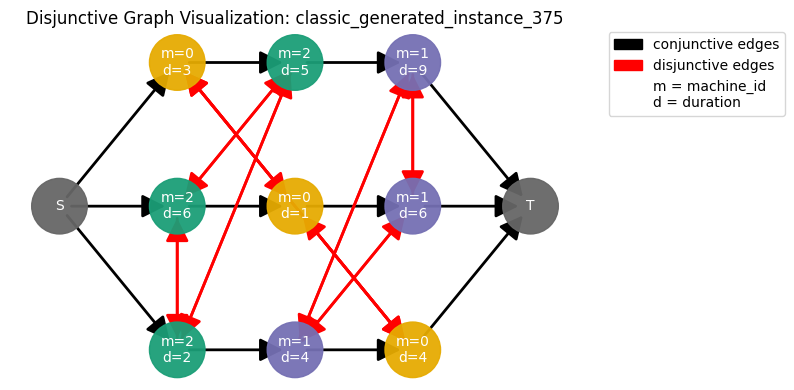

In [4]:
_ = plot_disjunctive_graph(instance)

In [5]:
optimized_solver = DispatchingRuleSolver(
    dispatching_rule=instance.metadata["dispatching_rule"]
)
non_optimized_solver = DispatchingRuleSolver(
    dispatching_rule=instance.metadata["dispatching_rule"],
    filter_bad_choices=False,
)

schedule = optimized_solver.solve(instance)
non_optimized_solution = non_optimized_solver.solve(instance)
best_solution = CPSolver().solve(instance)

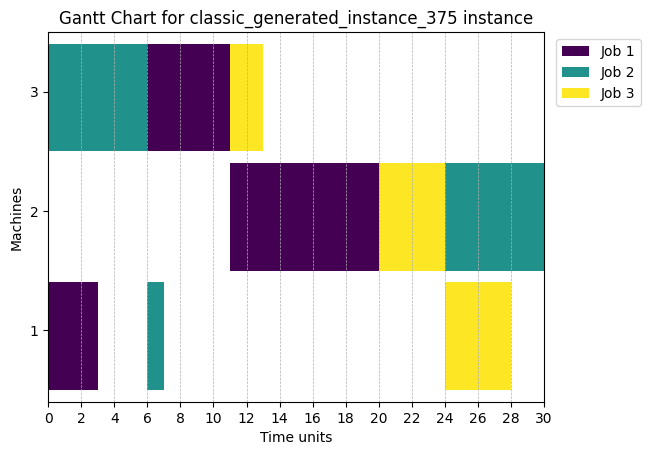

In [6]:
_ = plot_gantt_chart(schedule)

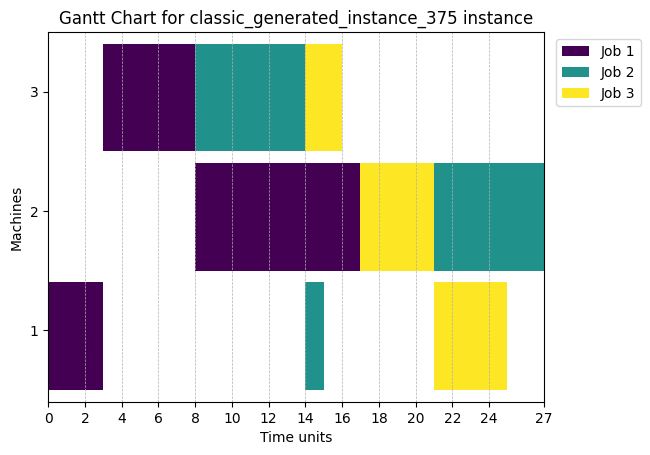

In [7]:
_ = plot_gantt_chart(non_optimized_solution, number_of_x_ticks=10)

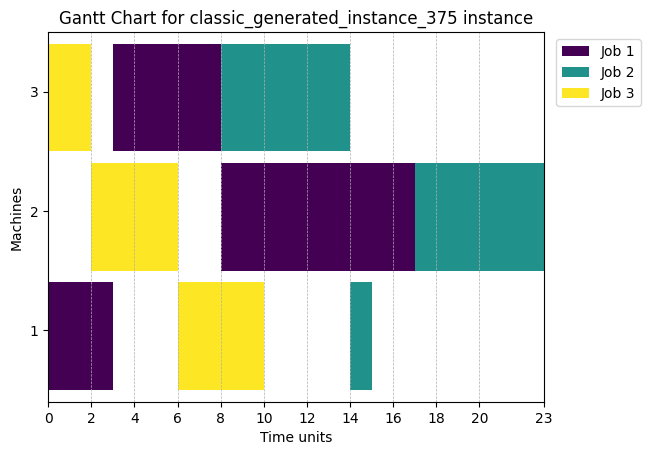

In [8]:
_ = plot_gantt_chart(best_solution, number_of_x_ticks=10)

### Test the effectiveness of the optimization

In [9]:
benchmark_instances = load_all_benchmark_instances()

# Update optimum makespan as the average of the lower bound and the upper bound
for instance in benchmark_instances.values():
    instance.metadata["estimated_optimum"] = (
        instance.metadata["lower_bound"] + instance.metadata["upper_bound"]
    ) / 2

In [10]:
import pandas as pd
import tqdm

optimized_solvers = {
    f"{dispatching_rule.name}_optimized": DispatchingRuleSolver(
        dispatching_rule
    )
    for dispatching_rule in DispatchingRule
}
non_optimized_solvers = {
    f"{dispatching_rule.name}_non_optimized": DispatchingRuleSolver(
        dispatching_rule, filter_bad_choices=False
    )
    for dispatching_rule in DispatchingRule
}
solvers = {**optimized_solvers, **non_optimized_solvers}

stats = {
    "instance": [],
    "optimum": [],
    "solver": [],
    "makespan": [],
    "gap": [],
}

for instance in tqdm.tqdm(benchmark_instances.values()):
    optimum = instance.metadata["estimated_optimum"]
    for solver_name, solver in solvers.items():
        schedule = solver(instance)
        makespan = schedule.makespan()

        stats["instance"].append(instance.name)
        stats["optimum"].append(optimum)
        stats["solver"].append(solver_name)
        stats["makespan"].append(makespan)
        stats["gap"].append((makespan - optimum) / optimum)

100%|██████████| 162/162 [00:42<00:00,  3.78it/s]


In [21]:
df = pd.DataFrame(stats)

In [12]:
df.groupby(["solver"]).agg({"gap": ["mean", "std"]}).sort_values(
    ("gap", "mean")
)

gap          
                                             mean       std
solver                                                     
FIRST_COME_FIRST_SERVED_optimized        0.292595  0.148838
MOST_OPERATIONS_REMAINING_optimized      0.292595  0.148838
MOST_WORK_REMAINING_optimized            0.320442  0.129749
FIRST_COME_FIRST_SERVED_non_optimized    0.416646  0.175278
MOST_OPERATIONS_REMAINING_non_optimized  0.416646  0.175278
RANDOM_optimized                         0.512329  0.192808
MOST_WORK_REMAINING_non_optimized        0.581878  0.196349
RANDOM_non_optimized                     1.071331  0.283334
SHORTEST_PROCESSING_TIME_optimized       1.368239  0.641254
SHORTEST_PROCESSING_TIME_non_optimized   4.814590  2.481640

In [13]:
# Add instance_type (instance'name without the number)
df["instance_type"] = df["instance"].apply(
    lambda x: "".join([i for i in x if not i.isdigit()])
)
df

,instance,optimum,solver,makespan,gap,instance_type
0,abz5,1234.0,SHORTEST_PROCESSING_TIME_optimized,2379,0.927877,abz
1,abz5,1234.0,FIRST_COME_FIRST_SERVED_optimized,1429,0.158023,abz
2,abz5,1234.0,MOST_WORK_REMAINING_optimized,1451,0.175851,abz
3,abz5,1234.0,MOST_OPERATIONS_REMAINING_optimized,1429,0.158023,abz
4,abz5,1234.0,RANDOM_optimized,1724,0.397083,abz
...,...,...,...,...,...,...
1615,ta80,5183.0,SHORTEST_PROCESSING_TIME_non_optimized,50817,8.804553,ta
1616,ta80,5183.0,FIRST_COME_FIRST_SERVED_non_optimized,6479,0.250048,ta
1617,ta80,5183.0,MOST_WORK_REMAINING_non_optimized,7955,0.534825,ta
1618,ta80,5183.0,MOST_OPERATIONS_REMAINING_non_optimized,6479,0.250048,ta


In [14]:
# Group by instance_type
df.groupby(["instance_type"]).agg({"gap": ["mean", "std"]})

gap          
                   mean       std
instance_type                    
abz            0.890422  1.177768
ft             0.513300  0.383817
la             0.644650  0.858441
orb            0.687005  0.448479
swv            0.868346  0.776763
ta             1.273112  1.966774
yn             1.387544  2.041877

In [15]:
df_most_work_remaining = df[df["solver"].str.contains("MOST_WORK_REMAINING")]

In [16]:
df_most_work_remaining.groupby(["instance_type", "solver"]).agg(
    {"gap": ["mean", "std"]}
)

gap          
                                                     mean       std
instance_type solver                                               
abz           MOST_WORK_REMAINING_non_optimized  0.456233  0.202741
              MOST_WORK_REMAINING_optimized      0.306607  0.097187
ft            MOST_WORK_REMAINING_non_optimized  0.488461  0.213527
              MOST_WORK_REMAINING_optimized      0.273490  0.059017
la            MOST_WORK_REMAINING_non_optimized  0.421745  0.159118
              MOST_WORK_REMAINING_optimized      0.226633  0.118579
orb           MOST_WORK_REMAINING_non_optimized  0.605967  0.217354
              MOST_WORK_REMAINING_optimized      0.341208  0.067384
swv           MOST_WORK_REMAINING_non_optimized  0.814586  0.267580
              MOST_WORK_REMAINING_optimized      0.403581  0.193436
ta            MOST_WORK_REMAINING_non_optimized  0.612947  0.104424
              MOST_WORK_REMAINING_optimized      0.343805  0.100561
yn            MOST_WORK_REMAINING_non_optimized  0.565180  0.079463
              MOST_WORK_REMAINING_optimized      0.376184  0.052869

In [22]:
# Add boolean column to check if the solver is optimized
df["optimized"] = ~df["solver"].str.contains("non_optimized")

In [18]:
df.groupby(["instance_type", "optimized"]).agg({"gap": ["mean", "std"]})

gap          
                             mean       std
instance_type optimized                    
abz           False      1.251430  1.542990
              True       0.529413  0.423953
ft            False      0.660299  0.473191
              True       0.366301  0.186921
la            False      0.930202  1.105723
              True       0.359098  0.301699
orb           False      0.889727  0.531185
              True       0.484282  0.200855
swv           False      1.185920  0.950531
              True       0.550772  0.324905
ta            False      1.882364  2.569629
              True       0.663860  0.631558
yn            False      1.976107  2.684794
              True       0.798981  0.787754

In [23]:
df.groupby(["optimized"]).agg({"gap": ["mean", "std"]})

gap          
               mean       std
optimized                    
False      1.460218  2.033609
True       0.557240  0.522292

### Note
The example instance was generated using the following code:
```python
import tqdm
from job_shop_lib import InstanceGenerator
from job_shop_lib.solvers import DispatchingRuleSolver, DispatchingRule
import json

generator = InstanceGenerator(
    num_jobs=3, num_machines=3, seed=0, duration_range=(1, 10)
)
n_trials = 1_000_000
dprs = [
    DispatchingRule.MOST_WORK_REMAINING,
    DispatchingRule.MOST_OPERATIONS_REMAINING,
]
found = False
for _ in tqdm.trange(n_trials):
    if found:
        break
    instance = generator.generate()
    for dispatching_rule in dprs:
        optimized_solver = DispatchingRuleSolver(
            dispatching_rule=dispatching_rule
        )
        non_optimized_solver = DispatchingRuleSolver(
            dispatching_rule=dispatching_rule,
            filter_bad_choices=False,
        )
        optimized_solution = optimized_solver.solve(instance)
        non_optimized_solution = non_optimized_solver.solve(instance)

        optimized_makespan = optimized_solution.makespan()
        non_optimized_makespan = non_optimized_solution.makespan()

        if optimized_makespan > non_optimized_makespan:
            print(
                f"Optimized makespan: {optimized_makespan}, "
                f"Non-optimized makespan: {non_optimized_makespan}"
            )
            print(instance)
            instance.metadata["optimized_makespan"] = optimized_makespan
            instance.metadata["non_optimized_makespan"] = (
                non_optimized_makespan
            )
            instance.metadata["dispatching_rule"] = dispatching_rule.value
            instance_dict = instance.to_dict()
            with open(
                "bad_choice_instance.json", "w", encoding="utf-8"
            ) as f:
                json.dump(instance_dict, f, indent=4)

            found = True
            break
```